# Ejmplo perceptron multicapa para clasificacion
### Examen Mayo 2024


## Librerias y carga del dataset

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Cargar datos
df = pd.read_csv('mushroom.csv')

## Limpieza de los Datos con Funcion

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_and_split2(df: pd.DataFrame,
                    col_objetivo: str,
                    test_size: float = 0.2,
                    random_state: int = 13):
    
    # Contar NaNs antes de limpiar
    nan_counts_before = df.isna().sum()  # cuenta de valores faltantes por col
    print("Valores faltantes antes de la limpieza:\n", nan_counts_before)

    # Se eliminan todas las filas que contienen al menos un valor nulo
    #df = df.dropna(how='any') 
    
    # 1. Extraer la col objetivo del resto de las características del DF, separar X e y
    y = df[col_objetivo].values  # objetivo como array numpy
    X = df.drop(columns=[col_objetivo])  # elimina la col objetivo

    # 2. Separar entre columnas numéricas y categoricas
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categoric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # 3. Definir pipeline para porcesar cols numericas
    # Vamos a quitar los NaN y una normalizacion a 0-1
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # sustituye NaN por media
        ('scaler', MinMaxScaler())  # normaliza valores al rango [0,1]
    ])

    # 4. Definir pipeline para porcesar cols categoricas
    # Vamos a quitar los NaN y hacer codificaion OneHot
    categoric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # sustituye NaN por moda
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # codifica categorias, OneHot
    ])

    # 5. Combinar los pipelines en el prepocesor
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_cols),  # aplica a num_cols
        ('cat', categoric_pipeline, categoric_cols)   # aplica a cat_cols
    ])

    # 6. Ajustar transformaciones y transformar datos
    X_processed = preprocessor.fit_transform(X)

    # Contar NaNs despues de la limpieza (ya no deberia haber)
    # DataFrame temporal para comprobalo
    nuevo_df = pd.DataFrame(X_processed)
    nan_cont_desp = nuevo_df.isna().sum()
    print("Valores faltantes después de la limpieza:\n", nan_cont_desp)

    # 7. Division en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y,
        test_size=test_size,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test



#Utilizamos la funcion para obtener los datos de entrenamiento y test
col_objetivo = "class"
X_train, X_test, y_train, y_test = clean_and_split2(df, col_objetivo)
print("Train shape:", X_train.shape)
print("Test  shape:", X_test.shape)


Valores faltantes antes de la limpieza:
 cap-diameter       2
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         2
stem-color         0
season             0
class              0
dtype: int64
Valores faltantes después de la limpieza:
 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Train shape: (43228, 8)
Test  shape: (10807, 8)


# Perceptron Multicapa MLP

In [3]:
# Perceptron Multicapa
from sklearn.neural_network import MLPClassifier # modelo de red neuronal de perceptrón multicapa
from sklearn.metrics import accuracy_score # función para calcular la proporción de predicciones correctas
model = MLPClassifier(hidden_layer_sizes=(60), max_iter=30000, alpha=0.01, learning_rate_init=0.01, random_state=13) 
# 20 : capas ocultas (valor normal) (1 nivel)
# 7000 : numero máximo de iteraciones (épocas) durante el entrenamiento (alto para que converja)
# 0.01 parámetro de regularización L2 (penalizacion moderada)
# tasa de aprendizaje inicial (Tasa más alta (0.01) (Ajuste de Pesos) = aprende más rápido pero puede ser inestable) (Tasa más baja (0.0001) = más estable pero más lento)
# 13 : semilla
model.fit(X_train, y_train)

# Obtener las predicciones del clasificador de scikit-learn
y_pred_MLP = model.predict(X_test)
ac = accuracy_score(y_pred_MLP,y_test)
print("Accuracy",ac)

Accuracy 0.9458684186175627


## Mostrar resultados:
### Matriz de Confusion

Matriz de confusion MLP:
[[4593  280]
 [ 305 5629]]


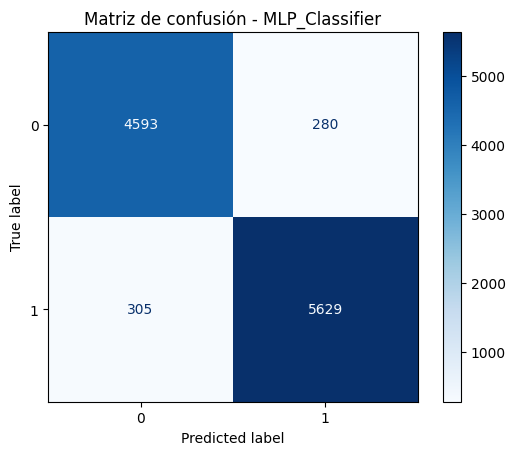


Falsos positivos MLP: 280

Falsos negativos MLP: 305

Accuracy 0.9458684186175627

precision_score 0.9526146556100863

recall_score 0.9486012807549713

f1_score 0.9506037321624589


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


cm_MLP = confusion_matrix(y_test, y_pred_MLP)
print("Matriz de confusion MLP:")
print(cm_MLP)


disp = ConfusionMatrixDisplay(confusion_matrix=cm_MLP)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de confusión - MLP_Classifier')
plt.show()

# (0,0) TN: Verdaderos negativos
# (0,1) FP: Falsos positivos (¡esto es lo que quieres!)
# (1,0) FN: Falsos negativos
# (1,1) TP: Verdaderos positivos

fp_mlp = cm_MLP[0, 1]
fn_mlp = cm_MLP[1, 0]
print("\nFalsos positivos MLP:", fp_mlp)
print("\nFalsos negativos MLP:", fn_mlp)

'''
Cuándo priorizar cada una:

    Si te preocupan FP (falsos positivos), examina precision.

    Si temes mas FN (falsos negativos), mira recall.

    El F1-score equilibra ambas.
'''
acc = accuracy_score(y_test, y_pred_MLP)
print("\nAccuracy",ac) #ya lo muestro antes al hacer el modelo
prec = precision_score(y_test, y_pred_MLP)
print("\nprecision_score",prec)
rec = recall_score(y_test, y_pred_MLP)
print("\nrecall_score",rec)
f1 = f1_score(y_test, y_pred_MLP)
print("\nf1_score",f1)